In [1]:
# Imports
from pathlib import Path

import matplotlib
import numpy as np
import xarray as xr
import regionmask
from matplotlib import pyplot as plt

import echoregions as er

In [2]:
# Show regionmask version
regionmask.__version__

'0.11.0'

In [3]:
# Set directories
DATA_DIR = Path("./echoregions/test_data/")
EVR_PATH = DATA_DIR / "transect.evr"
ZARR_PATH = DATA_DIR / "transect.zarr"

# Read in EVR and Sv data
r2d = er.read_evr(EVR_PATH)
da_Sv = xr.open_zarr(ZARR_PATH).Sv

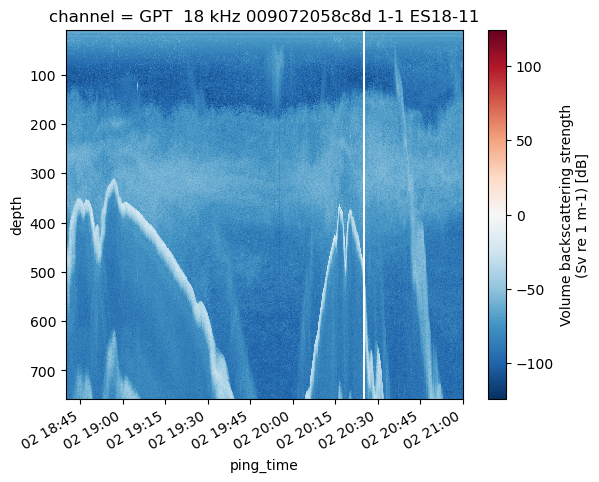

In [4]:
# Plot da_Sv
da_Sv.isel(channel=0).plot(yincrease=False)

In [5]:
# Show start and end times of da_Sv
earliest_time_da_Sv = da_Sv.ping_time[0].values
latest_time_da_Sv = da_Sv.ping_time[-1].values
print(f"Earliest Time {earliest_time_da_Sv}")
print(f"Latest Time {latest_time_da_Sv}")

Earliest Time 2019-07-02T18:40:00.000000000
Latest Time 2019-07-02T21:00:00.000000000


In [6]:
# Extract Region IDs and convert to Python float values
region_ids = r2d.data.region_id.astype(float).to_list()

for region_id in region_ids:
    print(f"Region ID : {int(region_id)}")
    left_time = r2d.select_region(region_id)["region_bbox_left"].values
    right_time = r2d.select_region(region_id)["region_bbox_right"].values
    print(f"Region BBox Left Time {left_time}")
    print(f"Region BBox Right Time {right_time}")
    depth_values = r2d.select_region(region_id)["depth"].values[0]
    print(f"Depth Values {depth_values}")
    print("-------------------------------------------------")

# As can be seen below, the only region that "should" overlap with the Sv data above is 18.
# All regions in between are in the specified time zone, but depth values are "NaN".

Region ID : 1
Region BBox Left Time ['2019-07-02T03:50:54.629500000']
Region BBox Right Time ['2019-07-02T08:10:09.425500000']
Depth Values [-9999.99  9999.99  9999.99 -9999.99]
-------------------------------------------------
Region ID : 2
Region BBox Left Time ['2019-07-02T12:32:30.175500000']
Region BBox Right Time ['2019-07-02T12:32:31.740500000']
Depth Values [-9999.99  9999.99  9999.99 -9999.99]
-------------------------------------------------
Region ID : 3
Region BBox Left Time ['2019-07-02T12:43:06.273000000']
Region BBox Right Time ['2019-07-02T12:43:10.758500000']
Depth Values [-9999.99  9999.99  9999.99 -9999.99]
-------------------------------------------------
Region ID : 4
Region BBox Left Time ['2019-07-02T12:54:59.931500000']
Region BBox Right Time ['2019-07-02T12:55:01.303000000']
Depth Values [-9999.99  9999.99  9999.99 -9999.99]
-------------------------------------------------
Region ID : 5
Region BBox Left Time ['2019-07-02T13:14:00.488000000']
Region BBox Right 

In [7]:
# Select channel w/ index 0
da_Sv_chan_0 = da_Sv.isel(channel=0)

# Set mask labels as region_id values
mask_labels = region_ids

# Replace nan depth in regions2d.
r2d.replace_nan_depth(inplace=True)

# Dataframe containing region information.
region_df = r2d.select_region(region_ids)

# Select only columns which are important.
region_df = region_df[["region_id", "time", "depth"]]

# Organize the regions in a format for region mask.
df = region_df.explode(["time", "depth"])

# Convert region time to integer timestamp.
df["time"] = matplotlib.dates.date2num(df["time"])

# Create a list of dataframes for each regions.
grouped = list(df.groupby("region_id"))

# Convert to list of numpy arrays which is an acceptable format to create region mask.
regions_np = [np.array(region[["time", "depth"]]) for id, region in grouped]

# Corresponding region ids converted to int.
region_ids_conv = [int(id) for id, region in grouped]

# Convert ping_time to unix_time since the masking does not work on datetime objects.
da_Sv_chan_0 = da_Sv_chan_0.assign_coords(
    unix_time=(
        "ping_time",
        matplotlib.dates.date2num(da_Sv_chan_0.coords["ping_time"].values),
    )
)


In [9]:
# Initialize region.
r = regionmask.Regions(outlines=regions_np, numbers=region_ids_conv)

# Error for overlapping regions when trying to perform 2D mask operation
M = r.mask(
    da_Sv_chan_0["unix_time"],
    da_Sv_chan_0["depth"],
    wrap_lon=False,
)

# I theorize that the overlap occurs when we mask region_ids 14-17 since these have NaN value depths that may
# not be translated as NaN value depths, i.e., they're treated as actual values. If this is the case, then they
# will completely overlap with themselves and of the valid masked regions 13 and 18.

ValueError: Found overlapping regions for ``overlap=None``. Please create a 3D mask. You may want to explicitely set ``overlap`` to ``True`` or ``False``.

Region ID 1


/home/ec2-user/mambaforge/envs/er_region_mask/lib/python3.9/site-packages/regionmask/core/_deprecate.py:108: UserWarning: No gridpoint belongs to any region. Returning an all-NaN mask.
  return func(*args, **kwargs)


<xarray.DataArray 'mask' (depth: 3955, ping_time: 1681)>
array([[nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       ...,
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan]])
Coordinates:
    channel       <U37 'GPT  18 kHz 009072058c8d 1-1 ES18-11'
  * depth         (depth) float64 9.15 9.34 9.529 9.719 ... 758.1 758.3 758.5
    range_sample  (depth) int64 ...
  * ping_time     (ping_time) datetime64[ns] 2019-07-02T18:40:00 ... 2019-07-...
    unix_time     (ping_time) float64 1.808e+04 1.808e+04 ... 1.808e+04
Attributes:
    standard_name:  region
    flag_values:    []
    flag_meanings:  
Unique Values [nan]


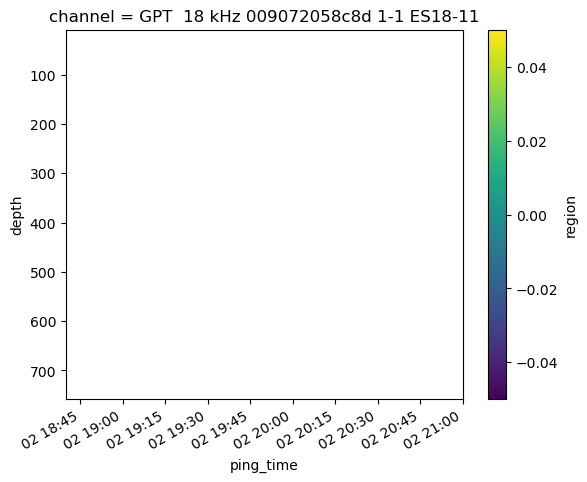

Region ID 2


/home/ec2-user/mambaforge/envs/er_region_mask/lib/python3.9/site-packages/regionmask/core/_deprecate.py:108: UserWarning: No gridpoint belongs to any region. Returning an all-NaN mask.
  return func(*args, **kwargs)


<xarray.DataArray 'mask' (depth: 3955, ping_time: 1681)>
array([[nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       ...,
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan]])
Coordinates:
    channel       <U37 'GPT  18 kHz 009072058c8d 1-1 ES18-11'
  * depth         (depth) float64 9.15 9.34 9.529 9.719 ... 758.1 758.3 758.5
    range_sample  (depth) int64 ...
  * ping_time     (ping_time) datetime64[ns] 2019-07-02T18:40:00 ... 2019-07-...
    unix_time     (ping_time) float64 1.808e+04 1.808e+04 ... 1.808e+04
Attributes:
    standard_name:  region
    flag_values:    []
    flag_meanings:  
Unique Values [nan]


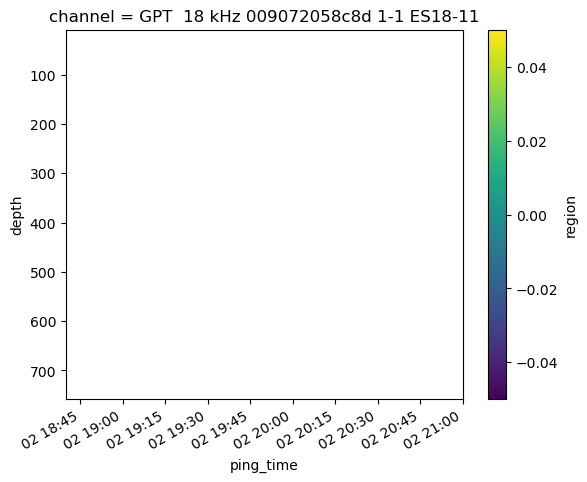

Region ID 3


/home/ec2-user/mambaforge/envs/er_region_mask/lib/python3.9/site-packages/regionmask/core/_deprecate.py:108: UserWarning: No gridpoint belongs to any region. Returning an all-NaN mask.
  return func(*args, **kwargs)


<xarray.DataArray 'mask' (depth: 3955, ping_time: 1681)>
array([[nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       ...,
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan]])
Coordinates:
    channel       <U37 'GPT  18 kHz 009072058c8d 1-1 ES18-11'
  * depth         (depth) float64 9.15 9.34 9.529 9.719 ... 758.1 758.3 758.5
    range_sample  (depth) int64 ...
  * ping_time     (ping_time) datetime64[ns] 2019-07-02T18:40:00 ... 2019-07-...
    unix_time     (ping_time) float64 1.808e+04 1.808e+04 ... 1.808e+04
Attributes:
    standard_name:  region
    flag_values:    []
    flag_meanings:  
Unique Values [nan]


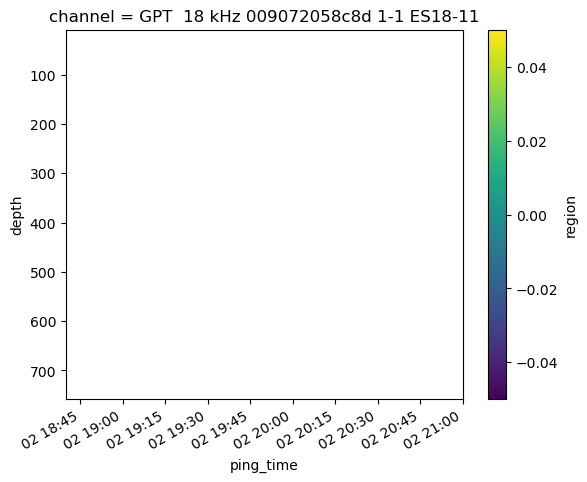

Region ID 4


/home/ec2-user/mambaforge/envs/er_region_mask/lib/python3.9/site-packages/regionmask/core/_deprecate.py:108: UserWarning: No gridpoint belongs to any region. Returning an all-NaN mask.
  return func(*args, **kwargs)


<xarray.DataArray 'mask' (depth: 3955, ping_time: 1681)>
array([[nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       ...,
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan]])
Coordinates:
    channel       <U37 'GPT  18 kHz 009072058c8d 1-1 ES18-11'
  * depth         (depth) float64 9.15 9.34 9.529 9.719 ... 758.1 758.3 758.5
    range_sample  (depth) int64 ...
  * ping_time     (ping_time) datetime64[ns] 2019-07-02T18:40:00 ... 2019-07-...
    unix_time     (ping_time) float64 1.808e+04 1.808e+04 ... 1.808e+04
Attributes:
    standard_name:  region
    flag_values:    []
    flag_meanings:  
Unique Values [nan]


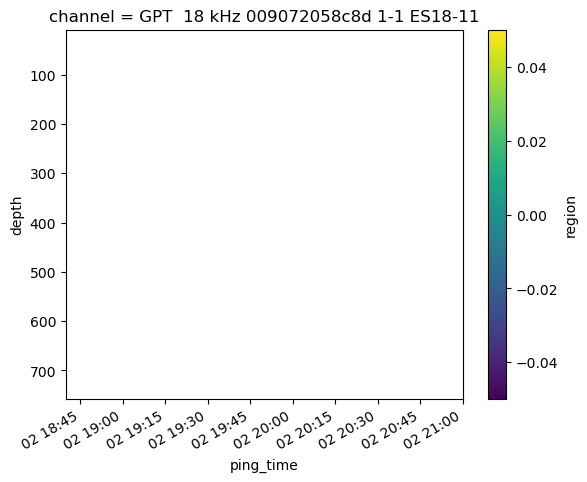

Region ID 5


/home/ec2-user/mambaforge/envs/er_region_mask/lib/python3.9/site-packages/regionmask/core/_deprecate.py:108: UserWarning: No gridpoint belongs to any region. Returning an all-NaN mask.
  return func(*args, **kwargs)


<xarray.DataArray 'mask' (depth: 3955, ping_time: 1681)>
array([[nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       ...,
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan]])
Coordinates:
    channel       <U37 'GPT  18 kHz 009072058c8d 1-1 ES18-11'
  * depth         (depth) float64 9.15 9.34 9.529 9.719 ... 758.1 758.3 758.5
    range_sample  (depth) int64 ...
  * ping_time     (ping_time) datetime64[ns] 2019-07-02T18:40:00 ... 2019-07-...
    unix_time     (ping_time) float64 1.808e+04 1.808e+04 ... 1.808e+04
Attributes:
    standard_name:  region
    flag_values:    []
    flag_meanings:  
Unique Values [nan]


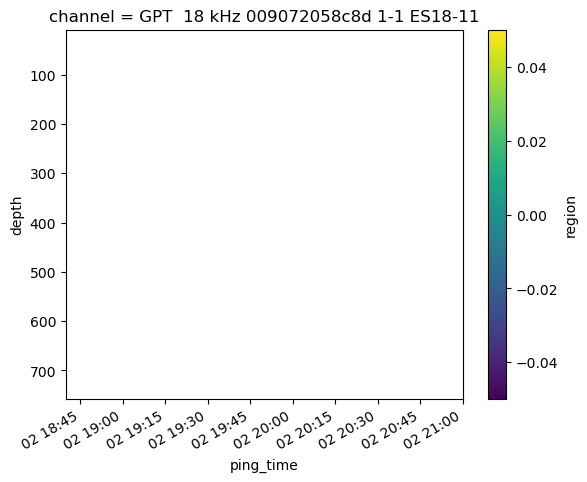

Region ID 6


/home/ec2-user/mambaforge/envs/er_region_mask/lib/python3.9/site-packages/regionmask/core/_deprecate.py:108: UserWarning: No gridpoint belongs to any region. Returning an all-NaN mask.
  return func(*args, **kwargs)


<xarray.DataArray 'mask' (depth: 3955, ping_time: 1681)>
array([[nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       ...,
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan]])
Coordinates:
    channel       <U37 'GPT  18 kHz 009072058c8d 1-1 ES18-11'
  * depth         (depth) float64 9.15 9.34 9.529 9.719 ... 758.1 758.3 758.5
    range_sample  (depth) int64 ...
  * ping_time     (ping_time) datetime64[ns] 2019-07-02T18:40:00 ... 2019-07-...
    unix_time     (ping_time) float64 1.808e+04 1.808e+04 ... 1.808e+04
Attributes:
    standard_name:  region
    flag_values:    []
    flag_meanings:  
Unique Values [nan]


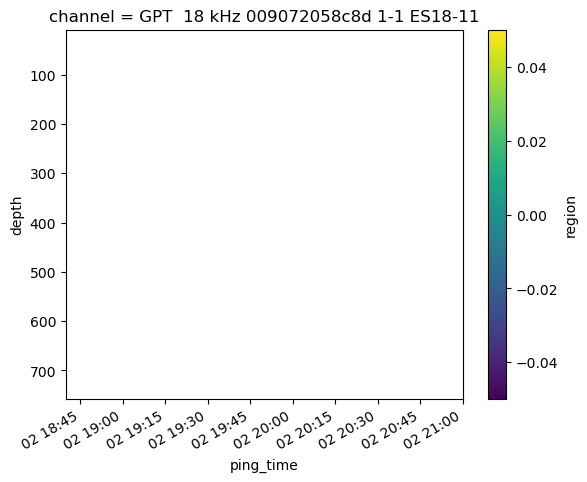

Region ID 7


/home/ec2-user/mambaforge/envs/er_region_mask/lib/python3.9/site-packages/regionmask/core/_deprecate.py:108: UserWarning: No gridpoint belongs to any region. Returning an all-NaN mask.
  return func(*args, **kwargs)


<xarray.DataArray 'mask' (depth: 3955, ping_time: 1681)>
array([[nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       ...,
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan]])
Coordinates:
    channel       <U37 'GPT  18 kHz 009072058c8d 1-1 ES18-11'
  * depth         (depth) float64 9.15 9.34 9.529 9.719 ... 758.1 758.3 758.5
    range_sample  (depth) int64 ...
  * ping_time     (ping_time) datetime64[ns] 2019-07-02T18:40:00 ... 2019-07-...
    unix_time     (ping_time) float64 1.808e+04 1.808e+04 ... 1.808e+04
Attributes:
    standard_name:  region
    flag_values:    []
    flag_meanings:  
Unique Values [nan]


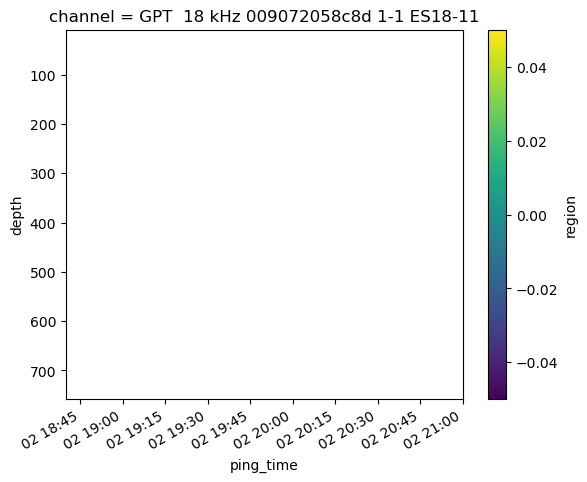

Region ID 8


/home/ec2-user/mambaforge/envs/er_region_mask/lib/python3.9/site-packages/regionmask/core/_deprecate.py:108: UserWarning: No gridpoint belongs to any region. Returning an all-NaN mask.
  return func(*args, **kwargs)


<xarray.DataArray 'mask' (depth: 3955, ping_time: 1681)>
array([[nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       ...,
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan]])
Coordinates:
    channel       <U37 'GPT  18 kHz 009072058c8d 1-1 ES18-11'
  * depth         (depth) float64 9.15 9.34 9.529 9.719 ... 758.1 758.3 758.5
    range_sample  (depth) int64 ...
  * ping_time     (ping_time) datetime64[ns] 2019-07-02T18:40:00 ... 2019-07-...
    unix_time     (ping_time) float64 1.808e+04 1.808e+04 ... 1.808e+04
Attributes:
    standard_name:  region
    flag_values:    []
    flag_meanings:  
Unique Values [nan]


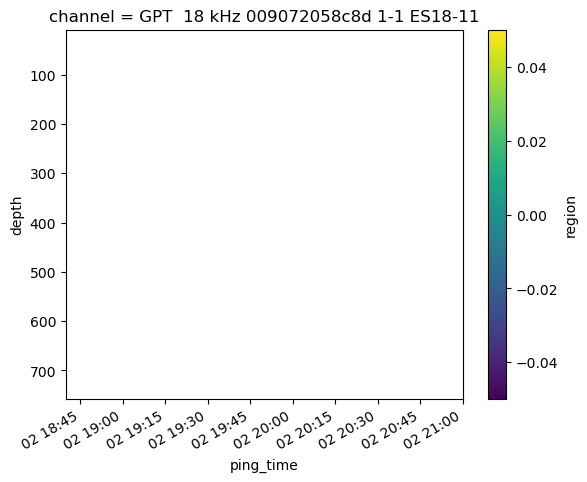

Region ID 9


/home/ec2-user/mambaforge/envs/er_region_mask/lib/python3.9/site-packages/regionmask/core/_deprecate.py:108: UserWarning: No gridpoint belongs to any region. Returning an all-NaN mask.
  return func(*args, **kwargs)


<xarray.DataArray 'mask' (depth: 3955, ping_time: 1681)>
array([[nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       ...,
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan]])
Coordinates:
    channel       <U37 'GPT  18 kHz 009072058c8d 1-1 ES18-11'
  * depth         (depth) float64 9.15 9.34 9.529 9.719 ... 758.1 758.3 758.5
    range_sample  (depth) int64 ...
  * ping_time     (ping_time) datetime64[ns] 2019-07-02T18:40:00 ... 2019-07-...
    unix_time     (ping_time) float64 1.808e+04 1.808e+04 ... 1.808e+04
Attributes:
    standard_name:  region
    flag_values:    []
    flag_meanings:  
Unique Values [nan]


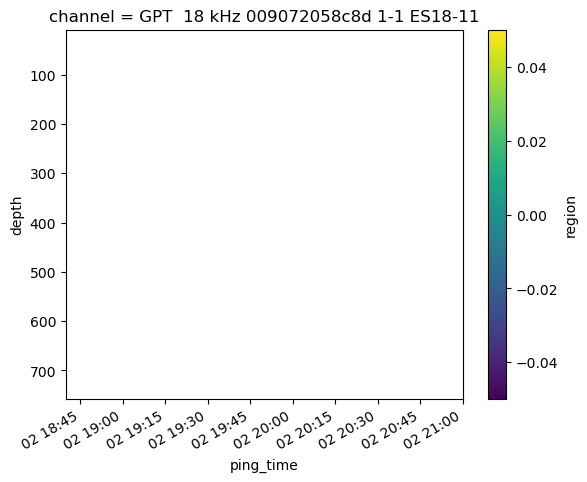

Region ID 10


/home/ec2-user/mambaforge/envs/er_region_mask/lib/python3.9/site-packages/regionmask/core/_deprecate.py:108: UserWarning: No gridpoint belongs to any region. Returning an all-NaN mask.
  return func(*args, **kwargs)


<xarray.DataArray 'mask' (depth: 3955, ping_time: 1681)>
array([[nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       ...,
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan]])
Coordinates:
    channel       <U37 'GPT  18 kHz 009072058c8d 1-1 ES18-11'
  * depth         (depth) float64 9.15 9.34 9.529 9.719 ... 758.1 758.3 758.5
    range_sample  (depth) int64 ...
  * ping_time     (ping_time) datetime64[ns] 2019-07-02T18:40:00 ... 2019-07-...
    unix_time     (ping_time) float64 1.808e+04 1.808e+04 ... 1.808e+04
Attributes:
    standard_name:  region
    flag_values:    []
    flag_meanings:  
Unique Values [nan]


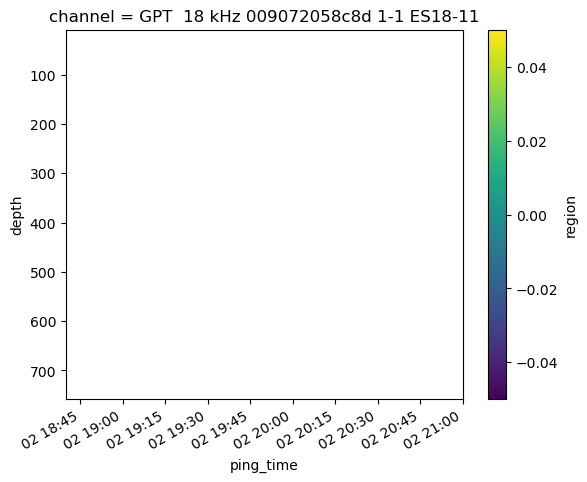

Region ID 11


/home/ec2-user/mambaforge/envs/er_region_mask/lib/python3.9/site-packages/regionmask/core/_deprecate.py:108: UserWarning: No gridpoint belongs to any region. Returning an all-NaN mask.
  return func(*args, **kwargs)


<xarray.DataArray 'mask' (depth: 3955, ping_time: 1681)>
array([[nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       ...,
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan]])
Coordinates:
    channel       <U37 'GPT  18 kHz 009072058c8d 1-1 ES18-11'
  * depth         (depth) float64 9.15 9.34 9.529 9.719 ... 758.1 758.3 758.5
    range_sample  (depth) int64 ...
  * ping_time     (ping_time) datetime64[ns] 2019-07-02T18:40:00 ... 2019-07-...
    unix_time     (ping_time) float64 1.808e+04 1.808e+04 ... 1.808e+04
Attributes:
    standard_name:  region
    flag_values:    []
    flag_meanings:  
Unique Values [nan]


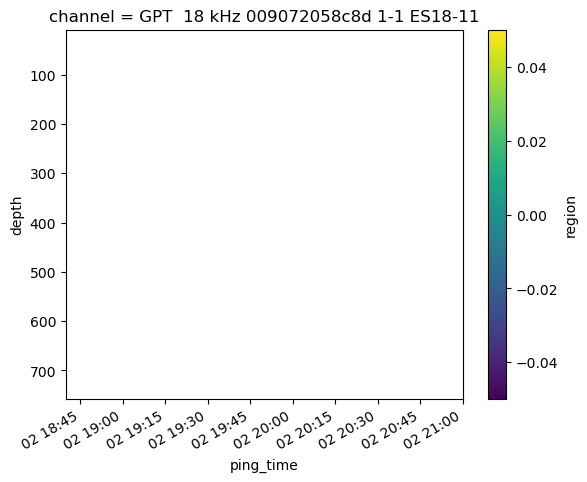

Region ID 12


/home/ec2-user/mambaforge/envs/er_region_mask/lib/python3.9/site-packages/regionmask/core/_deprecate.py:108: UserWarning: No gridpoint belongs to any region. Returning an all-NaN mask.
  return func(*args, **kwargs)


<xarray.DataArray 'mask' (depth: 3955, ping_time: 1681)>
array([[nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       ...,
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan]])
Coordinates:
    channel       <U37 'GPT  18 kHz 009072058c8d 1-1 ES18-11'
  * depth         (depth) float64 9.15 9.34 9.529 9.719 ... 758.1 758.3 758.5
    range_sample  (depth) int64 ...
  * ping_time     (ping_time) datetime64[ns] 2019-07-02T18:40:00 ... 2019-07-...
    unix_time     (ping_time) float64 1.808e+04 1.808e+04 ... 1.808e+04
Attributes:
    standard_name:  region
    flag_values:    []
    flag_meanings:  
Unique Values [nan]


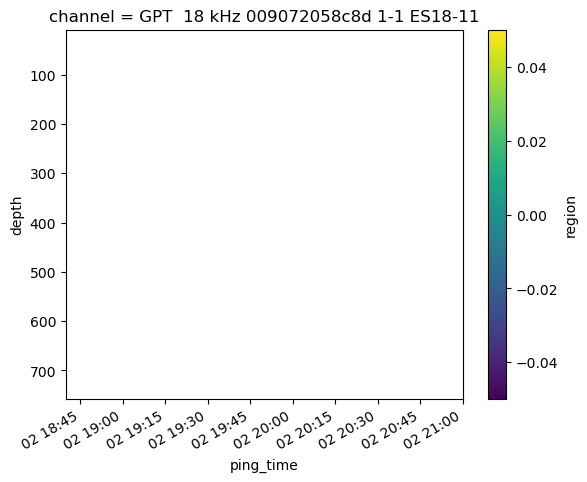

Region ID 13


/home/ec2-user/mambaforge/envs/er_region_mask/lib/python3.9/site-packages/regionmask/core/_deprecate.py:108: UserWarning: No gridpoint belongs to any region. Returning an all-NaN mask.
  return func(*args, **kwargs)


<xarray.DataArray 'mask' (depth: 3955, ping_time: 1681)>
array([[nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       ...,
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan]])
Coordinates:
    channel       <U37 'GPT  18 kHz 009072058c8d 1-1 ES18-11'
  * depth         (depth) float64 9.15 9.34 9.529 9.719 ... 758.1 758.3 758.5
    range_sample  (depth) int64 ...
  * ping_time     (ping_time) datetime64[ns] 2019-07-02T18:40:00 ... 2019-07-...
    unix_time     (ping_time) float64 1.808e+04 1.808e+04 ... 1.808e+04
Attributes:
    standard_name:  region
    flag_values:    []
    flag_meanings:  
Unique Values [nan]


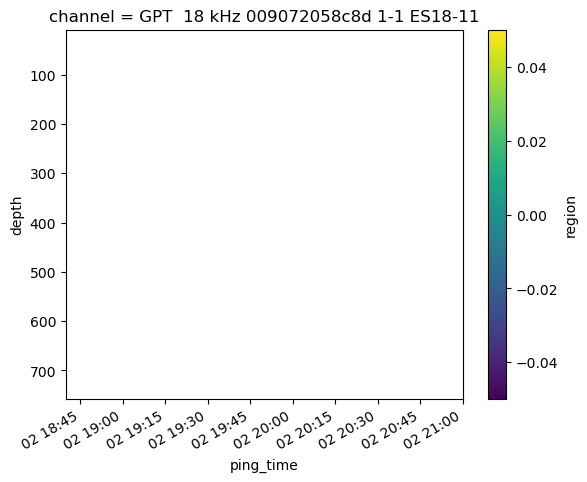

Region ID 14


/home/ec2-user/mambaforge/envs/er_region_mask/lib/python3.9/site-packages/regionmask/core/_deprecate.py:108: UserWarning: No gridpoint belongs to any region. Returning an all-NaN mask.
  return func(*args, **kwargs)


<xarray.DataArray 'mask' (depth: 3955, ping_time: 1681)>
array([[nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       ...,
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan]])
Coordinates:
    channel       <U37 'GPT  18 kHz 009072058c8d 1-1 ES18-11'
  * depth         (depth) float64 9.15 9.34 9.529 9.719 ... 758.1 758.3 758.5
    range_sample  (depth) int64 ...
  * ping_time     (ping_time) datetime64[ns] 2019-07-02T18:40:00 ... 2019-07-...
    unix_time     (ping_time) float64 1.808e+04 1.808e+04 ... 1.808e+04
Attributes:
    standard_name:  region
    flag_values:    []
    flag_meanings:  
Unique Values [nan]


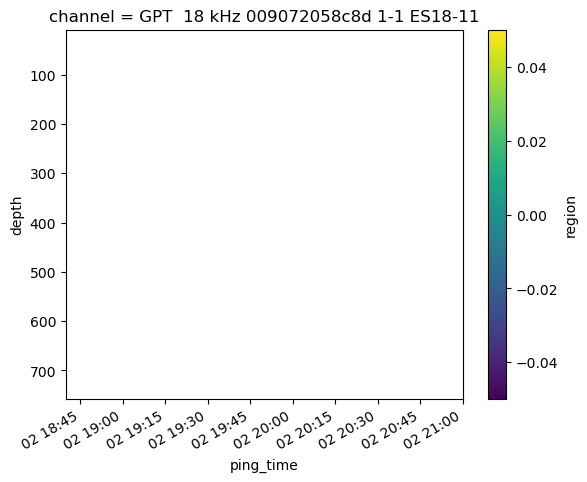

Region ID 15


/home/ec2-user/mambaforge/envs/er_region_mask/lib/python3.9/site-packages/regionmask/core/_deprecate.py:108: UserWarning: No gridpoint belongs to any region. Returning an all-NaN mask.
  return func(*args, **kwargs)


<xarray.DataArray 'mask' (depth: 3955, ping_time: 1681)>
array([[nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       ...,
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan]])
Coordinates:
    channel       <U37 'GPT  18 kHz 009072058c8d 1-1 ES18-11'
  * depth         (depth) float64 9.15 9.34 9.529 9.719 ... 758.1 758.3 758.5
    range_sample  (depth) int64 ...
  * ping_time     (ping_time) datetime64[ns] 2019-07-02T18:40:00 ... 2019-07-...
    unix_time     (ping_time) float64 1.808e+04 1.808e+04 ... 1.808e+04
Attributes:
    standard_name:  region
    flag_values:    []
    flag_meanings:  
Unique Values [nan]


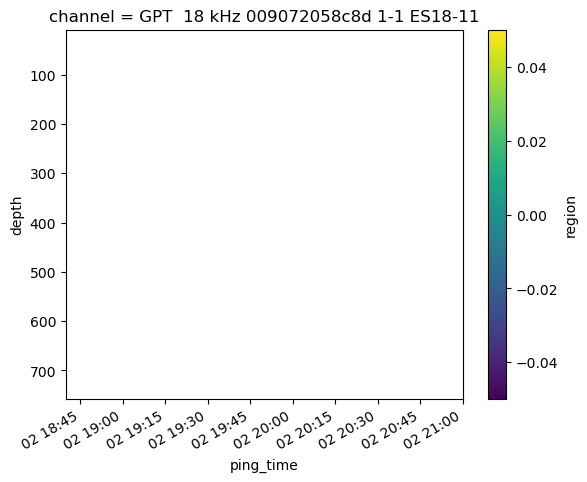

Region ID 16


/home/ec2-user/mambaforge/envs/er_region_mask/lib/python3.9/site-packages/regionmask/core/_deprecate.py:108: UserWarning: No gridpoint belongs to any region. Returning an all-NaN mask.
  return func(*args, **kwargs)


<xarray.DataArray 'mask' (depth: 3955, ping_time: 1681)>
array([[nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       ...,
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan]])
Coordinates:
    channel       <U37 'GPT  18 kHz 009072058c8d 1-1 ES18-11'
  * depth         (depth) float64 9.15 9.34 9.529 9.719 ... 758.1 758.3 758.5
    range_sample  (depth) int64 ...
  * ping_time     (ping_time) datetime64[ns] 2019-07-02T18:40:00 ... 2019-07-...
    unix_time     (ping_time) float64 1.808e+04 1.808e+04 ... 1.808e+04
Attributes:
    standard_name:  region
    flag_values:    []
    flag_meanings:  
Unique Values [nan]


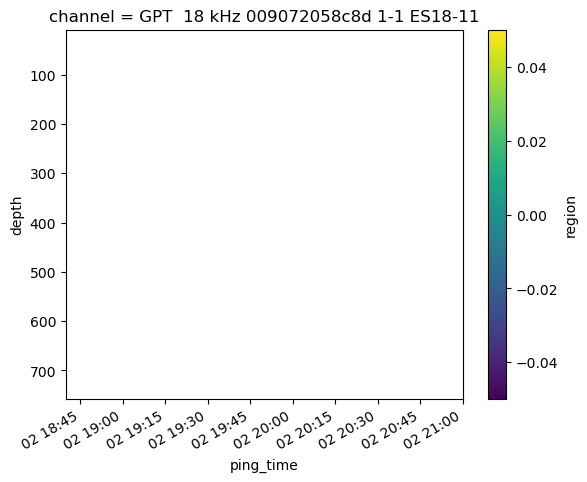

Region ID 17


/home/ec2-user/mambaforge/envs/er_region_mask/lib/python3.9/site-packages/regionmask/core/_deprecate.py:108: UserWarning: No gridpoint belongs to any region. Returning an all-NaN mask.
  return func(*args, **kwargs)


<xarray.DataArray 'mask' (depth: 3955, ping_time: 1681)>
array([[nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       ...,
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan]])
Coordinates:
    channel       <U37 'GPT  18 kHz 009072058c8d 1-1 ES18-11'
  * depth         (depth) float64 9.15 9.34 9.529 9.719 ... 758.1 758.3 758.5
    range_sample  (depth) int64 ...
  * ping_time     (ping_time) datetime64[ns] 2019-07-02T18:40:00 ... 2019-07-...
    unix_time     (ping_time) float64 1.808e+04 1.808e+04 ... 1.808e+04
Attributes:
    standard_name:  region
    flag_values:    []
    flag_meanings:  
Unique Values [nan]


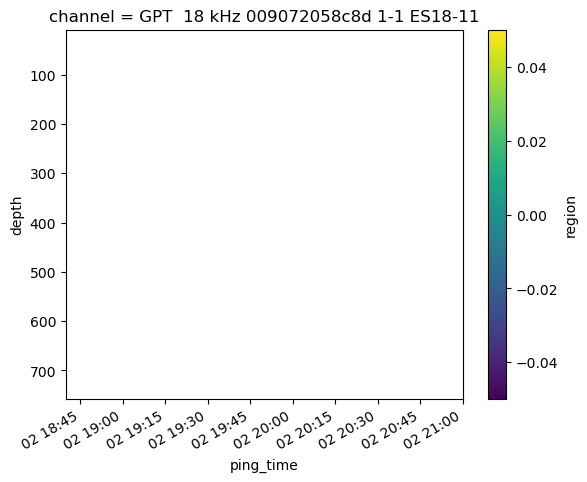

Region ID 18


/home/ec2-user/mambaforge/envs/er_region_mask/lib/python3.9/site-packages/regionmask/core/_deprecate.py:108: UserWarning: No gridpoint belongs to any region. Returning an all-NaN mask.
  return func(*args, **kwargs)


<xarray.DataArray 'mask' (depth: 3955, ping_time: 1681)>
array([[nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       ...,
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan]])
Coordinates:
    channel       <U37 'GPT  18 kHz 009072058c8d 1-1 ES18-11'
  * depth         (depth) float64 9.15 9.34 9.529 9.719 ... 758.1 758.3 758.5
    range_sample  (depth) int64 ...
  * ping_time     (ping_time) datetime64[ns] 2019-07-02T18:40:00 ... 2019-07-...
    unix_time     (ping_time) float64 1.808e+04 1.808e+04 ... 1.808e+04
Attributes:
    standard_name:  region
    flag_values:    []
    flag_meanings:  
Unique Values [nan]


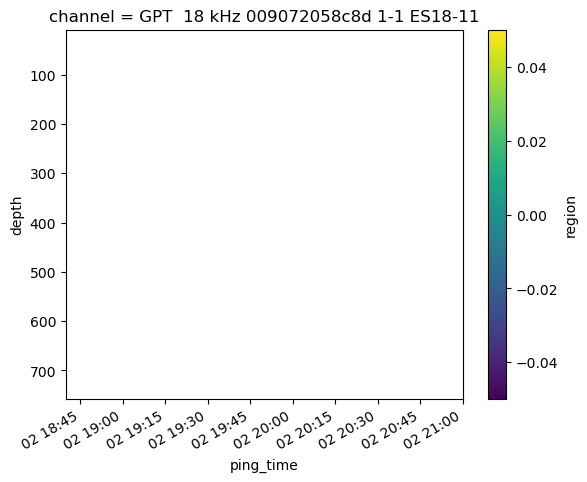

Region ID 19


/home/ec2-user/mambaforge/envs/er_region_mask/lib/python3.9/site-packages/regionmask/core/_deprecate.py:108: UserWarning: No gridpoint belongs to any region. Returning an all-NaN mask.
  return func(*args, **kwargs)


<xarray.DataArray 'mask' (depth: 3955, ping_time: 1681)>
array([[nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       ...,
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan]])
Coordinates:
    channel       <U37 'GPT  18 kHz 009072058c8d 1-1 ES18-11'
  * depth         (depth) float64 9.15 9.34 9.529 9.719 ... 758.1 758.3 758.5
    range_sample  (depth) int64 ...
  * ping_time     (ping_time) datetime64[ns] 2019-07-02T18:40:00 ... 2019-07-...
    unix_time     (ping_time) float64 1.808e+04 1.808e+04 ... 1.808e+04
Attributes:
    standard_name:  region
    flag_values:    []
    flag_meanings:  
Unique Values [nan]


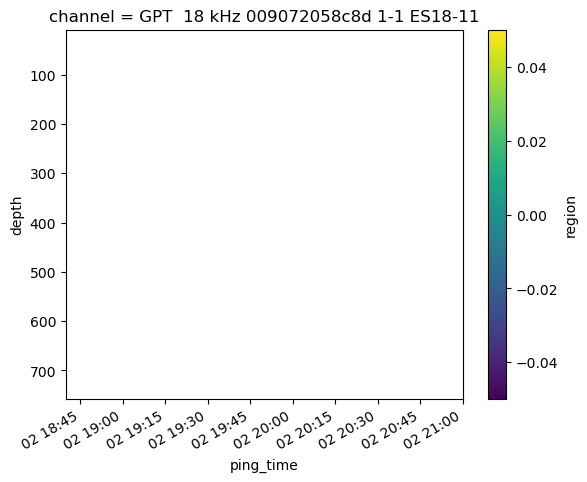

In [11]:
for region_id in region_ids_conv:
    print(f"Region ID {region_id}")
    # Initialize region for one region_id.
    r = regionmask.Regions(outlines=regions_np, numbers=[region_id])

    # 2D Mask
    M = r.mask(
        da_Sv_chan_0["unix_time"],
        da_Sv_chan_0["depth"],
        wrap_lon=False,
    )
    print(M)
    
    # Print Unique Values
    print(f"Unique Values {np.unique(M.data)}")

    M.plot(yincrease=False)
    plt.show()